In [1]:
import numpy as np
import xarray as xr
import netCDF4
import matplotlib.pyplot as plt
import numpy.ma as ma
import pandas as pd
import os
from datetime import datetime
import glob
from tqdm import tqdm
from rasterio.enums import Resampling
from multiprocessing import Pool
from itertools import product
import rioxarray

# Define configs and functions

In [2]:
data_dir = r"/home/waves/projects/smap-drydown/data"
SMAPL3_dir = "SPL3SMP"
datarods_dir = "datarods"
SMAPL4_dir = "SPL4SMGP"
SMAPL4_grid_dir = "SMAPL4SMGP_EASEreference"
rangeland_dir = "rap-vegetation-cover-v3"

start_year = 2015
end_year = 2022

In [3]:
def create_output_dir(out_dir):
    # Create and save the datarods  
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
        print(f"created {out_dir}")
    return out_dir

def get_filepath_from_pattern(filename_pattern, directory):
    file_paths = glob.glob(os.path.join(directory, filename_pattern))
    print(f"{filename_pattern}: {len(file_paths)} ... {len(file_paths):.1f} yrs of data available")
    return file_paths


In [4]:
class EASEgrid_template():
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.row_index, self.column_index, self.longitude, self.latitude = self.get_grid_coordinate()
        self.varname = "SPL3SMP"
        self.timestep = 365
        self.filenames = self.get_filepath()
        self.data = self.get_template_dataset()
        
    def get_grid_coordinate(self):
        SMAPL3_grid_sample = os.path.join(self.data_dir, r"SPL3SMP/SMAP_L3_SM_P_20150331_R18290_001.h5")

        # %%
        ncf = netCDF4.Dataset(SMAPL3_grid_sample, diskless=True, persist=False)
        nch_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')
        nch_pm = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')

        # %%
        # Return as regular numpy array rather than masked array
        _latitude = ma.getdata(nch_am.variables['latitude'][:].filled(fill_value=np.nan), subok=True)
        _longitude = ma.getdata(nch_am.variables['longitude'][:].filled(fill_value=np.nan), subok=True)
        _EASE_column_index = ma.getdata(nch_am.variables['EASE_column_index'][:].astype(int).filled(fill_value=-1), subok=True)
        _EASE_row_index = ma.getdata(nch_am.variables['EASE_row_index'][:].astype(int).filled(fill_value=-1), subok=True)

        # %%
        # Coordinates with no data are skipped --- fill them
        latitude = np.nanmax(_latitude, axis=1)
        EASE_row_index = np.nanmax(_EASE_row_index, axis=1)
        longitude = np.nanmax(_longitude, axis=0)
        EASE_column_index = np.nanmax(_EASE_column_index, axis=0)
        
        return EASE_row_index, EASE_column_index, longitude, latitude
    
    def get_filepath(self):
        filepaths = get_filepath(filename_pattern = f'SMAP_L3_SM_P_*.h5', directory=f"{data_dir}/{self.varname}")
        return filepaths
    
    def get_template_dataset(self):
        _ds_SMAPL3 = xr.open_dataset(self.filenames[0], engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable=['soil_moisture'])
        ds_SMAPL3_coord_template = _ds_SMAPL3.assign_coords({'x':self.longitude, 'y':self.latitude}).rio.write_crs("epsg:4326")
        return ds_SMAPL3_coord_template

# Read SMAPL3 grid coordinate

In [5]:
SMAPL3_grid_sample = os.path.join(data_dir, r"SPL3SMP/SMAP_L3_SM_P_20150331_R18290_001.h5")
# %%
ncf = netCDF4.Dataset(SMAPL3_grid_sample, diskless=True, persist=False)
nch_am = ncf.groups.get('Soil_Moisture_Retrieval_Data_AM')
nch_pm = ncf.groups.get('Soil_Moisture_Retrieval_Data_PM')

# %%
# Return as regular numpy array rather than masked array
_latitude = ma.getdata(nch_am.variables['latitude'][:].filled(fill_value=np.nan), subok=True)
_longitude = ma.getdata(nch_am.variables['longitude'][:].filled(fill_value=np.nan), subok=True)
_EASE_column_index = ma.getdata(nch_am.variables['EASE_column_index'][:].astype(int).filled(fill_value=-1), subok=True)
_EASE_row_index = ma.getdata(nch_am.variables['EASE_row_index'][:].astype(int).filled(fill_value=-1), subok=True)

# %%
# Coordinates with no data are skipped --- fill them
latitude = np.nanmax(_latitude, axis=1)
EASE_row_index = np.nanmax(_EASE_row_index, axis=1)
longitude = np.nanmax(_longitude, axis=0)
EASE_column_index = np.nanmax(_EASE_column_index, axis=0)

filepaths = get_filepath_from_pattern(filename_pattern = f'SMAP_L3_SM_P_*.h5', directory=f"{data_dir}/SPL3SMP")
_ds_SMAPL3 = xr.open_dataset(filepaths[0], engine='rasterio', group='Soil_Moisture_Retrieval_Data_AM', variable=['soil_moisture'])
ds_SMAPL3_coord_template = _ds_SMAPL3.assign_coords({'x':longitude, 'y':latitude}).rio.write_crs("epsg:4326")
ease_template = ds_SMAPL3_coord_template.Soil_Moisture_Retrieval_Data_AM_soil_moisture
ease_template

SMAP_L3_SM_P_*.h5: 2675 ... 2675.0 yrs of data available


<xarray.DataArray 'Soil_Moisture_Retrieval_Data_AM_soil_moisture' (band: 1,
                                                                   y: 406,
                                                                   x: 964)> Size: 2MB
[391384 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float32 4kB -179.8 -179.4 -179.1 ... 179.1 179.4 179.8
  * y            (y) float32 2kB 83.63 81.48 79.77 78.3 ... -79.77 -81.48 -83.63
    spatial_ref  int64 8B 0
Attributes:
    coordinates:  /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Re...
    long_name:    Representative DCA soil moisture measurement for the Earth ...
    units:        cm**3/cm**3
    valid_max:    0.5
    valid_min:    0.02

# Create rangeland data

In [6]:
varname = "rangeland_avg"
out_dir = create_output_dir(os.path.join(data_dir, datarods_dir, varname))

In [7]:
filenames = get_filepath_from_pattern(filename_pattern=f'vegetation-cover-v3-*.tif', directory=os.path.join(data_dir, "rap-vegetation-cover-v3"))
filenames

vegetation-cover-v3-*.tif: 8 ... 8.0 yrs of data available


['/home/waves/projects/smap-drydown/data/rap-vegetation-cover-v3/vegetation-cover-v3-2022.tif',
 '/home/waves/projects/smap-drydown/data/rap-vegetation-cover-v3/vegetation-cover-v3-2019.tif',
 '/home/waves/projects/smap-drydown/data/rap-vegetation-cover-v3/vegetation-cover-v3-2017.tif',
 '/home/waves/projects/smap-drydown/data/rap-vegetation-cover-v3/vegetation-cover-v3-2016.tif',
 '/home/waves/projects/smap-drydown/data/rap-vegetation-cover-v3/vegetation-cover-v3-2018.tif',
 '/home/waves/projects/smap-drydown/data/rap-vegetation-cover-v3/vegetation-cover-v3-2015.tif',
 '/home/waves/projects/smap-drydown/data/rap-vegetation-cover-v3/vegetation-cover-v3-2020.tif',
 '/home/waves/projects/smap-drydown/data/rap-vegetation-cover-v3/vegetation-cover-v3-2021.tif']

In [11]:
_ds = rioxarray.open_rasterio(filenames[0])
ds = _ds.rio.write_crs('epsg:4326', inplace=True)
bbox = ds.rio.bounds()
print(f"Bounding Box: {bbox}")
left, bottom, right, top = [-81.739, 24.396, -66.949, 47.459] #bbox
ds
# data._FillValue

Bounding Box: (-124.76979458874112, 24.518347870172978, -66.86969143457303, 49.393776065783484)


<xarray.DataArray (band: 6, y: 92304, x: 214847)> Size: 119GB
[118987424928 values with dtype=uint8]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 2MB -124.8 -124.8 -124.8 ... -66.87 -66.87 -66.87
  * y            (y) float64 738kB 49.39 49.39 49.39 49.39 ... 24.52 24.52 24.52
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0

In [12]:
band_num = 6
import re

# Using regular expression to find year pattern in the string
match = re.search(r'\d{4}', filenames[0])
record_year = match.group() if match else "Year not found"
record_year

'2022'

In [13]:
subset_ease_template = ease_template.sel(x=slice(left, right), y=slice(top, bottom))
subset_ease_template

<xarray.DataArray 'Soil_Moisture_Retrieval_Data_AM_soil_moisture' (band: 1,
                                                                   y: 66, x: 40)> Size: 11kB
[2640 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float32 160B -81.6 -81.22 -80.85 ... -67.78 -67.41 -67.03
  * y            (y) float32 264B 47.32 46.91 46.5 46.1 ... 25.22 24.91 24.6
    spatial_ref  int64 8B 0
Attributes:
    coordinates:  /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Re...
    long_name:    Representative DCA soil moisture measurement for the Earth ...
    units:        cm**3/cm**3
    valid_max:    0.5
    valid_min:    0.02

In [14]:
veg_ds = ds['band'== band_num]

In [15]:
import time


In [16]:
veg_ds

<xarray.DataArray (y: 92304, x: 214847)> Size: 20GB
[19831237488 values with dtype=uint8]
Coordinates:
    band         int64 8B 1
  * x            (x) float64 2MB -124.8 -124.8 -124.8 ... -66.87 -66.87 -66.87
  * y            (y) float64 738kB 49.39 49.39 49.39 49.39 ... 24.52 24.52 24.52
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0

In [22]:
start_time = time.time()

grid_interval_y_min = abs(
    subset_ease_template.y.data[0] - subset_ease_template.y.data[1]
)
grid_interval_x_min = abs(
    subset_ease_template.x.data[0] - subset_ease_template.x.data[1]
)
# For maximum edge using the last two elements
grid_interval_y_max = abs(
    subset_ease_template.y.data[-1] - subset_ease_template.y.data[-2]
)
grid_interval_x_max = abs(
    subset_ease_template.x.data[-1] - subset_ease_template.x.data[-2]
)

new_lat_bounds = np.linspace(
    start=min(subset_ease_template.y) - grid_interval_y_min,
    stop=max(subset_ease_template.y) + grid_interval_y_max,
    num=len(subset_ease_template.y),
)
new_lon_bounds = np.linspace(
    start=min(subset_ease_template.x) - grid_interval_x_min,
    stop=max(subset_ease_template.x) + grid_interval_x_max,
    num=len(subset_ease_template.x),
)

# # Example of defining new grid boundaries manually or from subset_ease_template
# new_lat_bounds = np.linspace(start=min(subset_ease_template.y), stop=max(subset_ease_template.y), num=len(subset_ease_template.y) + 1)
# new_lon_bounds = np.linspace(start=min(subset_ease_template.x), stop=max(subset_ease_template.x), num=len(subset_ease_template.x) + 1)

# Grouping by these new bins
grouped = veg_ds.groupby_bins('y', new_lat_bounds).mean()
veg_ds_resampled = grouped.groupby_bins('x', new_lon_bounds).mean()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time taken for the operation: {elapsed_time} seconds")

veg_ds_resampled

Time taken for the operation: 618.2908639907837 seconds


<xarray.DataArray (y_bins: 65, x_bins: 39)> Size: 20kB
array([[221.4998283 , 255.        , 255.        , ..., 255.        ,
        255.        , 255.        ],
       [218.29073962, 188.37722074, 235.13190587, ..., 255.        ,
        255.        , 255.        ],
       [255.        , 255.        , 151.47500029, ..., 255.        ,
        255.        , 255.        ],
       ...,
       [255.        , 255.        , 255.        , ..., 215.0595505 ,
        255.        , 255.        ],
       [255.        , 255.        , 255.        , ..., 235.96059313,
        255.        , 255.        ],
       [255.        , 255.        , 255.        , ..., 255.        ,
        255.        , 255.        ]])
Coordinates:
    band         int64 8B 1
    spatial_ref  int64 8B 0
  * y_bins       (y_bins) object 520B (24.184, 24.545] ... (47.273, 47.634]
  * x_bins       (x_bins) object 312B (-81.971, -81.578] ... (-67.052, -66.66]
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     255
    scale_factor:   1.0
    add_offset:     0.0

In [24]:
subset_ease_template

<xarray.DataArray 'Soil_Moisture_Retrieval_Data_AM_soil_moisture' (band: 1,
                                                                   y: 66, x: 40)> Size: 11kB
[2640 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float32 160B -81.6 -81.22 -80.85 ... -67.78 -67.41 -67.03
  * y            (y) float32 264B 47.32 46.91 46.5 46.1 ... 25.22 24.91 24.6
    spatial_ref  int64 8B 0
Attributes:
    coordinates:  /Soil_Moisture_Retrieval_Data_AM/latitude /Soil_Moisture_Re...
    long_name:    Representative DCA soil moisture measurement for the Earth ...
    units:        cm**3/cm**3
    valid_max:    0.5
    valid_min:    0.02

In [23]:
new_ds = xr.DataArray(
    data=veg_ds_resampled.data,
    dims=['y', 'x'],
    coords={
    'y': np.flip(subset_ease_template.y.data),
    'x': subset_ease_template.x.data
    }
)
new_ds.attrs['crs'] = 'EPSG:4326'

ValueError: conflicting sizes for dimension 'y': length 65 on the data but length 66 on coordinate 'y'

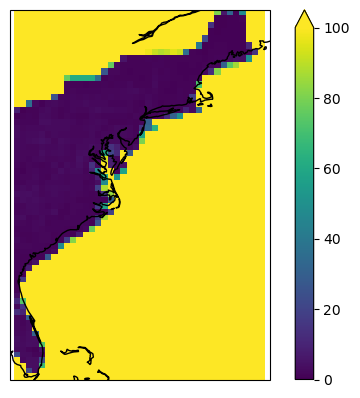

In [ ]:
import cartopy.crs as ccrs
projection = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': projection})
conus_extent = [-125, -66.5, 24.5, 49.5]
east_extent = [-82, -66.5, 25, 47]
cal_extent = [-124.5, -114.0, 32.5, 42.0]
# Plot the new data
new_ds.plot(ax=ax, transform=projection, vmin=0, vmax=100)
ax.set_extent(east_extent, crs=ccrs.PlateCarree())
ax.coastlines()
plt.show()

In [20]:
out_dir = create_output_dir(os.path.join(data_dir, 'rangeland_avg_resampled'))


In [ ]:
out_filepath = os.path.join(out_dir, f"{record_year}_band{band_num}_test.nc")
new_ds.to_netcdf(path=out_filepath)